# Classez des images à l'aide d'algorithmes de Deep Learning

On cherche à créer un algorithme qui va idntifier la race d'un chien à partir d'une photo de celui-ci. La première étape est donc de préparer les images à étudier.

## Préparation des données

### Traitement des images

Nous utiliserons la base de données de photographies de chiens *Stanford Dogs Dataset*. Commençons par importer quelques bibliothèques python dont nous aurons besoin.

In [1]:
import numpy as np
from PIL import Image, ImageOps
import os
from tqdm import tqdm
import random as rd
import matplotlib.pyplot as plt
import pandas as pd

Nous allons faire un peu de pré-processing, pour que l'image numérique soit plus efficacement traitée par nos algorithmes. Nous allons donc redimensionner les images pour avoir un carré de $150\times 150$ pixels, avant de corriger l'exposition et les contrastes grâce aux outils de la librairie *Pillow*.

In [2]:
#On crée une fonction qui fera toutes les transformations d'image nécessaires
def traitement_image(img, contrast_cutoff = 2, size = 150):
    #Conversion de l'image de RGBA vers RGB si nécessaire (ImageOps ne supporte pas le format RGBA)
    if img.mode == 'RGBA':
        img = convert_rgba_rgb(img)
    #Redimension de l'image
    img = ImageOps.fit(img, (size, size), method = Image.BILINEAR, bleed = 0.0, centering =(0.5, 0.5))
    #Etirement de l'histogramme si nécessaire
    img = ImageOps.autocontrast(img, cutoff = contrast_cutoff, ignore = contrast_cutoff)
    #Egalisation de l'histogramme
    img = ImageOps.equalize(img, mask = None)
    return img

#Certaines images utilisent le format de couleurs RGBA, qu'il faut convertir en RGB en remplaçant la transparence par du blanc
def convert_rgba_rgb(img):
    img.load() # required for png.split()
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask=img.split()[3]) # 3 is the alpha channel
    return background

Nous allons formater notre base d'images en transformatn chacune des photos disponibles, mais aussi en les séparant en deux jeux de données, un pour l'entraînement du modèle et l'autre pour l'évaluation de ses performances.

In [3]:
#On crée une fonction qui va préparer nos dossiers d'images, prenant en paramètres le répertoire d'entrée
#où sont stockées les images à traiter, l'adresse du répertoire de sortie où stocker le résultat après transformation
#et la proportion de données à mettre de côté pour le jeu d'évaluation. Nous préciserons également quelle
#proportion des données nous souhaitons utiliser, et si nous souhaitons omettre des classes ou simplement réduire
#le nombre de données en conservant toutes les classes (peut amener de grandes pertes d'information)
def prepare_data(in_dir, out_dir, size = 150, split_test = 0.2, sparse_data = 1., sparse_classes = False):
    #On initialise le générateur aléatoire et on prépare certaines variables d'intérêt
    labels = []
    out_train = os.path.join(out_dir, 'train')
    out_test = os.path.join(out_dir, 'test')
    rd.seed(0)
        
    #On va considérer chaque dossier dans le répertoire d'entrée comme une classe pour nos images
    for folder in os.listdir(in_dir):
        #On vérifie si cette classe sera conservée dans notre jeu de données
        alea = rd.random()
        if not sparse_classes or alea < sparse_data:
            #La race de chien est précédée d'un numéro d'identification qui ne nous intéresse pas
            etiquette = folder[folder.find('-')+1:]
            #On sauvegarde l'étiquette de la classe concernée
            labels.append(etiquette)
        
            #On va transformer chaque image dans le dossier, tqdm permettra de suivre la progression du traitement
            for file in tqdm(os.listdir(os.path.join(in_dir, folder))):
                #On vérifie si cette image sera conservée dans notre jeu de données
                alea = rd.random()
                if sparse_classes or alea < sparse_data:
                    #On construit le chemin d'accès jusqu'à l'image
                    img_path = os.path.join(os.path.join(in_dir, folder), file)
                
                    #On ouvre l'image avant de la transformer avec notre fonction précédemment écrite
                    img = Image.open(img_path)
                    img = traitement_image(img, size)
            
                    #On génère un nombre aléatoire uniforme dans [0,1] pour savoir dans quel jeu de données placer l'image
                    alea = rd.random()
                    #On construit le chemin d'accès pour la destination, selon si l'image est dans le jeu de train ou de test
                    if alea > split_test:
                        repertoire = os.path.join(out_train, etiquette)
                    else:
                        repertoire = os.path.join(out_test, etiquette)
                    #Si le répertoire n'existe pas encore, on le crée
                    if not os.path.exists(repertoire):
                        os.makedirs(repertoire)
                    out_path = os.path.join(repertoire, file)
                    #On sauvegarde l'image
                    img = img.save(out_path)
    #On renvoie la liste de toutes les étiquettes
    return labels

Nous commencerons par travailler sur une banque de données réduite, avec seulement $5\%$ des races de chiens disponibles (entre $5$ et $7$), dans le but d'évaluer l'efficacité de notre approche tout en ayant des temps d'exécution réduits.

In [4]:
#On prépare les chemins d'accès des répertoires d'entrée et de sortie, ainsi que la taille d'images voulue
in_dir = "database/original"
out_dir = "database_partial"
size = 150

#On prépare nos images, avant de lister les étiquettes présentes
labels = prepare_data(in_dir, out_dir, size=size, sparse_data = .05, sparse_classes = True)
print(labels)

100%|███████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 118.47it/s]

['Norwich_terrier', 'Scotch_terrier', 'Lhasa', 'German_short-haired_pointer', 'Great_Dane']


### Chargement des données

Maintenant que nos images ont été formatées pour l'étude, il va nous falloir les charger au format *numpy array*. On commence par récupérer les noms des différentes classes et y associer une étiquette arbitraire dans $\mathbb{N}$.

In [5]:
#On crée un dictionnaire avec des indices associés à chaque classe possible
class_names = labels
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
#On extraie le nombre de classes différentes
nb_classes = len(class_names)

A présent nous allons charger chaque banque de données (celle d'entraînement et celle de test) dans des *array*. On pensera à mélanger les images, car lors du chargement elles sont rangées par classe et cela pourrait biaiser le modèle lors d'un l'entraînement séquentiel.

In [6]:
#On va charger nos images sous forme d'array de la librairie numpy, à partir des emplacements donnés en paramètres
#sous la forme d'une liste
def load_data(datasets, class_names_label):
    output = []
    
    #On va charger chaque banque de données une à une
    for dataset in datasets:
        
        #On prépare les listes d'images et d'étiquettes
        images = []
        labels = []
        
        #On affiche quelle banque de données on traite actuellement
        print("Loading {}".format(dataset))
        
        #On va explorer chaque dossier présent, qui correspondent chacun à une classe différente
        for folder in os.listdir(dataset):
            #On prépare l'étiquette de l'image
            label = class_names_label[folder]
            
            #On charge chaque image une par une
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                #On charge l'image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = Image.open(img_path)
                
                #On ajoute l'image et son étiquette à nos deux listes
                images.append(np.array(image))
                labels.append(np.array(label))
        
        #On transforme nos listes (pour la database actuelle) en array
        images = np.array(images)
        labels = np.array(labels)   
        #Avant de les ajouter à la liste finale renvoyée
        output.append((images, labels))
    #On renvoie les images et les étiquettes pour CHAQUE jeu de données
    return output

In [7]:
from sklearn.utils import shuffle
#On liste les chemins d'accès des jeux de train et de test
datasets = ['database_partial/train', 'database_partial/test']
#On récupère nos jeux de données
(train_images, train_labels), (test_images, test_labels) = load_data(datasets, class_names_label)
#On mélange les images du jeu d'entraînement, pour éviter un biais lors de l'entraînement séquentiel
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Loading database_partial/train


100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1300.16it/s]


Loading database_partial/test


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1113.93it/s]


### Analyse des images

On va à présent analyser notre jeu d'entraînement, pour voir quelles sont les répartitions des différentes classes, combien d'images avons-nous, afficher quelques exemples, etc...

In [8]:
#On récupère le nombre d'images dans les deux jeux de données
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
#On les affiche, ainsi que la taille choisie pour les images
print ("Nombre d'images d'entraînement : {}".format(n_train))
print ("Nombre d'images d'évaluation : {}".format(n_test))
print ("Chaque image est de taille : {} pixels par {} pixels".format(size, size))

Nombre d'images d'entraînement : 676
Nombre d'images d'évaluation : 161
Chaque image est de taille : 150 pixels par 150 pixels


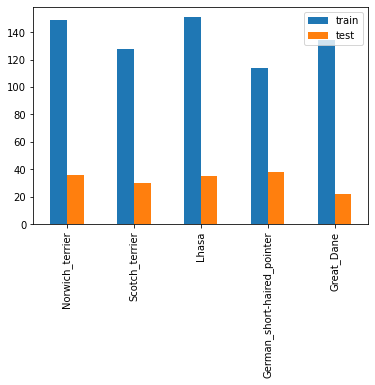

In [9]:
#On compte et affiche combien il y a d'images de chaque classe dans chaque jeu de données
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

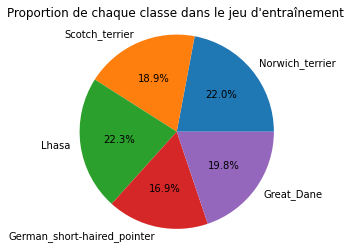

In [10]:
#On calcule et affiche les proportions de chaque classe dans le jeu d'entraînement
plt.pie(train_counts, explode=np.zeros(nb_classes), labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Proportion de chaque classe dans le jeu d'entraînement")
plt.show()

In [11]:
#Cette fonction affiche une image au hasard, pour vérifier que la base de données s'est bien chargée
def display_random_image(class_names, images, labels):    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

#Cette fonction fait de même, mais en affichant 25 images pour avoir une meilleur vue d'ensemble de la database
def display_examples(class_names, images, labels):    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Quelques images au hasard", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if i<len(images):
            plt.imshow(images[i], cmap=plt.cm.binary)
            plt.xlabel(class_names[labels[i]])
    plt.show()

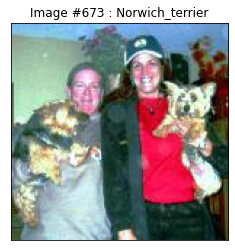

In [12]:
#On affiche une image aléatoire de notre jeu d'entraînement
display_random_image(class_names, train_images, train_labels)

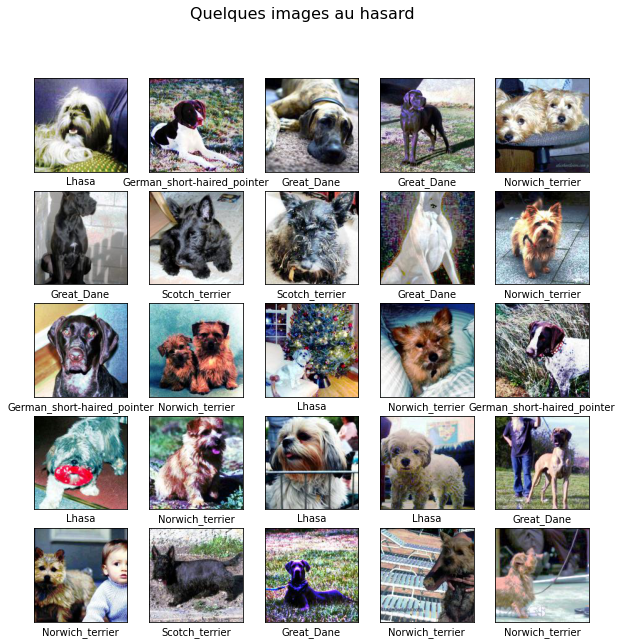

In [13]:
#On affiche 25 images pour visualiser notre jeu de données
display_examples(class_names, train_images, train_labels)

Nous allons renormaliser les valeurs numériques de nos images, afin d'avoir des variables dans $[0,1]$ plutôt que $[0,255]$.

In [14]:
#On renormalise les valeurs numériques pour avoir des entrées entre 0 et 1
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Classification par un CNN

Nous allons construire un réseau de neurones convolutionnel en empilant successivement une couche de convolution, une couche de pooling, une 2ème couche de convolution, une 2ème couche de pooling et enfin 2 couches fully-connected. La dernière devra comporter autant de noeuds que de classes dans notre base de données.

In [15]:
import tensorflow as tf

#On construit notre CNN en empilant les couches successives
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])

#On compile le modèle
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

On entraîne à présent notre modèle sur le jeu de train avec la méthode *fit*.

In [16]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 26s 306ms/step - loss: 3.3473 - accuracy: 0.1907 - val_loss: 1.6887 - val_accuracy: 0.1985
Epoch 2/20
5/5 [==============================] - 0s 92ms/step - loss: 1.6275 - accuracy: 0.2241 - val_loss: 1.6036 - val_accuracy: 0.1838
Epoch 3/20
5/5 [==============================] - 0s 92ms/step - loss: 1.5809 - accuracy: 0.2796 - val_loss: 1.5926 - val_accuracy: 0.2132
Epoch 4/20
5/5 [==============================] - 0s 92ms/step - loss: 1.4927 - accuracy: 0.4111 - val_loss: 1.5571 - val_accuracy: 0.2647
Epoch 5/20
5/5 [==============================] - 0s 91ms/step - loss: 1.2955 - accuracy: 0.5889 - val_loss: 1.5803 - val_accuracy: 0.3456
Epoch 6/20
5/5 [==============================] - 0s 91ms/step - loss: 1.0575 - accuracy: 0.6667 - val_loss: 1.6181 - val_accuracy: 0.3456
Epoch 7/20
5/5 [==============================] - 0s 92ms/step - loss: 0.8575 - accuracy: 0.7444 - val_loss: 1.5166 - val_accuracy: 0.3603
Epoch 8/20
5/5 [=========

Nous allons afficher les indicateurs de performances pour analyser l'efficacité de l'apprentissage de notre modèle, à savoir l'évolution de la précision et de la fonction de perte sur le jeu d'entraînement au fil des epochs.

In [17]:
#Cette fonction affiche les performances au cours de l'entraînement du modèle
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

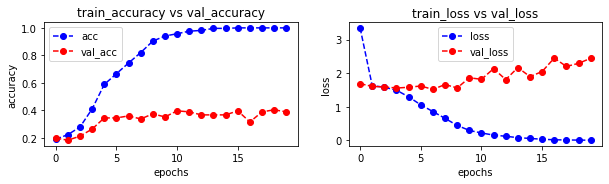

In [18]:
#On affiche les performances au cours de l'entraînement
plot_accuracy_loss(history)

Il y a clairement du sur-apprentissage, et on peut sûrement améliorer les performances sur le jeu d'évaluation.

In [19]:
test_loss = model.evaluate(test_images, test_labels)

6/6 [==============================] - 1s 112ms/step - loss: 2.5971 - accuracy: 0.3727


In [20]:
#On fait les prédictions sur le jeu de test
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1)

6/6 [==============================] - 0s 12ms/step


In [21]:
#Cette fonction permettra d'afficher des exemples d'images mal classées par notre algorithme
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names, mislabeled_images, mislabeled_labels)


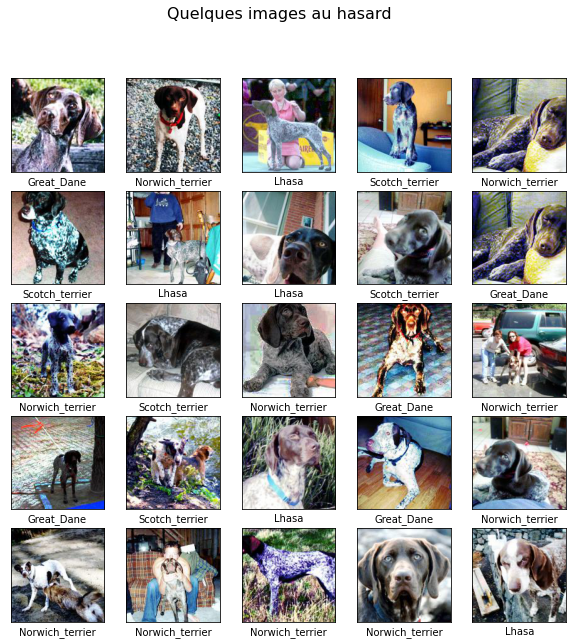

In [22]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Pour voir plus en détail quelles sont les erreurs faites par notre classifieur, nous allons afficher la matrice de confusion.

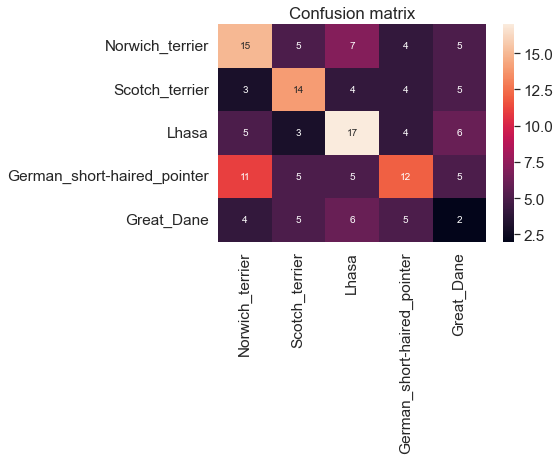

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)


CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Optimisation des paramètres

Une bonne partie des images sont bien classées, mais nous allons voir si modifier les paramètres permet de réduire le nombre d'erreurs et d'améliorer les performances. Le "score" à battre est une perte de $2.2881$ et une précision de $0.3727$ sur le jeu de test. Nous commencerons par remplacer la fonction de perte par la **divergence de Kullback-Leibler**. 

In [24]:
#On construit notre CNN en empilant les couches successives
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On compile le modèle
model.compile(optimizer = 'adam', loss = 'kl_divergence', metrics=['accuracy'])

In [25]:
#On entraîne à présent notre modèle sur le jeu de train avec la méthode fit.
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 1s 135ms/step - loss: 14.3964 - accuracy: 0.1704 - val_loss: 6.7895 - val_accuracy: 0.1838
Epoch 2/20
5/5 [==============================] - 0s 92ms/step - loss: 6.3112 - accuracy: 0.2019 - val_loss: 6.5251 - val_accuracy: 0.1838
Epoch 3/20
5/5 [==============================] - 0s 92ms/step - loss: 6.2260 - accuracy: 0.2000 - val_loss: 6.5126 - val_accuracy: 0.1838
Epoch 4/20
5/5 [==============================] - 0s 95ms/step - loss: 6.2170 - accuracy: 0.2019 - val_loss: 6.5103 - val_accuracy: 0.2059
Epoch 5/20
5/5 [==============================] - 0s 92ms/step - loss: 6.2152 - accuracy: 0.2056 - val_loss: 6.5090 - val_accuracy: 0.1912
Epoch 6/20
5/5 [==============================] - 0s 91ms/step - loss: 6.2144 - accuracy: 0.1630 - val_loss: 6.5088 - val_accuracy: 0.1765
Epoch 7/20
5/5 [==============================] - 0s 90ms/step - loss: 6.2143 - accuracy: 0.1667 - val_loss: 6.5088 - val_accuracy: 0.1765
Epoch 8/20
5/5 [=========

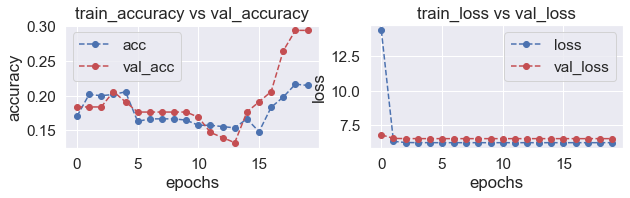

In [26]:
#On affiche les performances au cours de l'entraînement
plot_accuracy_loss(history)

In [27]:
test_loss = model.evaluate(test_images, test_labels)

6/6 [==============================] - 0s 13ms/step - loss: 6.2478 - accuracy: 0.2298


In [28]:
#On fait les prédictions sur le jeu de test
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1)

6/6 [==============================] - 0s 13ms/step


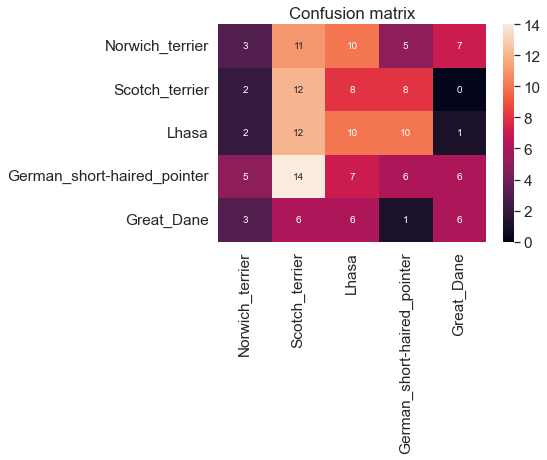

In [29]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Les résultats sont clairement moins bons qu'avec l'**entropie croisée** comme fonction de perte. Nous allons changer la méthode de *pooling* pour voir son impact sur les performances.

In [30]:
#On construit notre CNN en empilant les couches successives
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On compile le modèle
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
#On entraîne à présent notre modèle sur le jeu de train avec la méthode fit.
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 1s 130ms/step - loss: 2.4740 - accuracy: 0.2500 - val_loss: 1.8144 - val_accuracy: 0.1838
Epoch 2/20
5/5 [==============================] - 0s 91ms/step - loss: 1.6264 - accuracy: 0.2333 - val_loss: 1.6040 - val_accuracy: 0.1912
Epoch 3/20
5/5 [==============================] - 0s 92ms/step - loss: 1.5711 - accuracy: 0.2426 - val_loss: 1.5909 - val_accuracy: 0.1912
Epoch 4/20
5/5 [==============================] - 0s 91ms/step - loss: 1.4907 - accuracy: 0.3185 - val_loss: 1.5742 - val_accuracy: 0.2353
Epoch 5/20
5/5 [==============================] - 0s 92ms/step - loss: 1.3427 - accuracy: 0.4667 - val_loss: 1.6212 - val_accuracy: 0.3235
Epoch 6/20
5/5 [==============================] - 0s 91ms/step - loss: 1.2237 - accuracy: 0.5259 - val_loss: 1.5397 - val_accuracy: 0.3309
Epoch 7/20
5/5 [==============================] - 0s 91ms/step - loss: 1.0140 - accuracy: 0.6648 - val_loss: 1.7232 - val_accuracy: 0.3382
Epoch 8/20
5/5 [==========

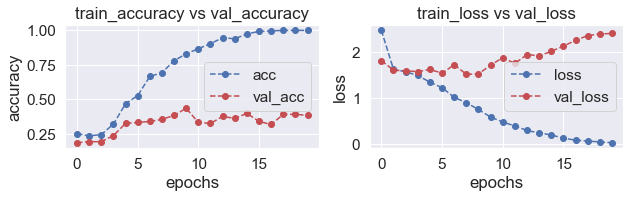

In [32]:
#On affiche les performances au cours de l'entraînement
plot_accuracy_loss(history)

In [33]:
test_loss = model.evaluate(test_images, test_labels)

6/6 [==============================] - 0s 14ms/step - loss: 2.4753 - accuracy: 0.3727


In [34]:
#On fait les prédictions sur le jeu de test
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1)

6/6 [==============================] - 0s 13ms/step


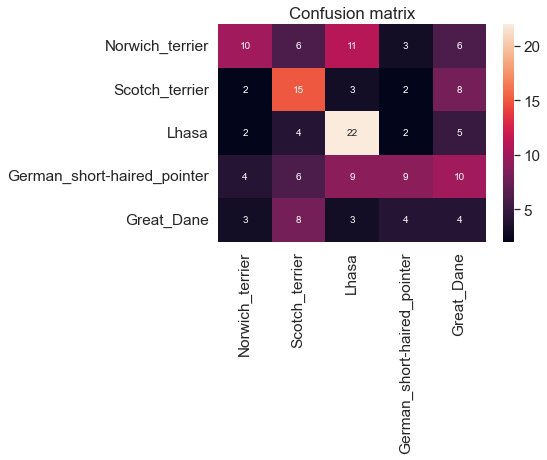

In [35]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Visiblement le **MaxPooling** est légèrement plus efficace. Nous allons changer un dernier hyperparamètre, à savoir ajouter un **padding**, i.e. des pixels noirs autour de l'image, lors de la convolution afin que la grille de features fasse la même dimension que l'image d'origine. Cela évitera de perdre de l'information sur les bords des images.

In [36]:
#On construit notre CNN en empilant les couches successives
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On compile le modèle
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
#On entraîne à présent notre modèle sur le jeu de train avec la méthode fit.
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 2s 191ms/step - loss: 4.4601 - accuracy: 0.2111 - val_loss: 1.7960 - val_accuracy: 0.3382
Epoch 2/20
5/5 [==============================] - 0s 99ms/step - loss: 1.7592 - accuracy: 0.2370 - val_loss: 1.6243 - val_accuracy: 0.2059
Epoch 3/20
5/5 [==============================] - 0s 96ms/step - loss: 1.6039 - accuracy: 0.2426 - val_loss: 1.5958 - val_accuracy: 0.1765
Epoch 4/20
5/5 [==============================] - 0s 95ms/step - loss: 1.5756 - accuracy: 0.2667 - val_loss: 1.5842 - val_accuracy: 0.3603
Epoch 5/20
5/5 [==============================] - 0s 96ms/step - loss: 1.5367 - accuracy: 0.4556 - val_loss: 1.5436 - val_accuracy: 0.4118
Epoch 6/20
5/5 [==============================] - 0s 99ms/step - loss: 1.4391 - accuracy: 0.4741 - val_loss: 1.5069 - val_accuracy: 0.3603
Epoch 7/20
5/5 [==============================] - 0s 96ms/step - loss: 1.3377 - accuracy: 0.4667 - val_loss: 1.5004 - val_accuracy: 0.3603
Epoch 8/20
5/5 [==========

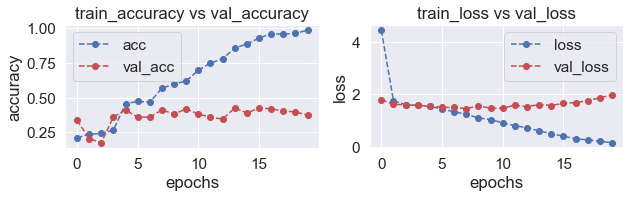

In [38]:
#On affiche les performances au cours de l'entraînement
plot_accuracy_loss(history)

In [39]:
test_loss = model.evaluate(test_images, test_labels)

6/6 [==============================] - 0s 22ms/step - loss: 1.9499 - accuracy: 0.3851


In [40]:
#On fait les prédictions sur le jeu de test
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1)

6/6 [==============================] - 0s 13ms/step


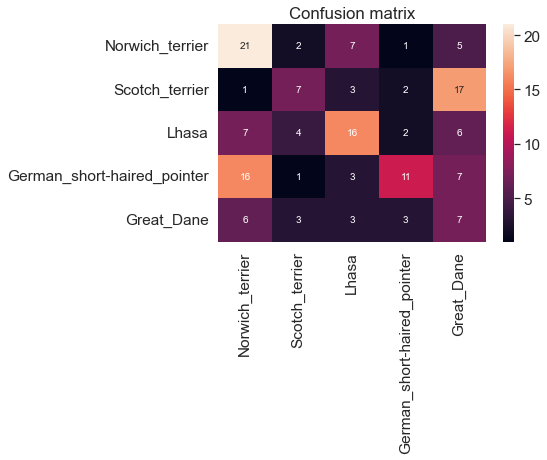

In [41]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Ces choix ont nettement amélioré les performances, nous conserverons donc ces derniers paramètres. On notera un net sur-apprentissage, qui nous poussera sûrement à réconsidérer le nombre d'**epochs** une fois que nous passerons au modèle final.

## Transfer Learning

Nous allons utiliser la même approche mais avec un CNN déjà entraîné. Cela permettra de gagner du temps (l'entraînement du modèle sera déjà **en partie** réalisé) mais aussi de profiter des avantages d'une database plus grande (bien que comportant beaucoup d'images qui ne nous intéressent pas dans notre problème). Nous allons importer l'algorithme VGG16, plus précisément la partie "*détection de features*" de ce CNN (nous n'utiliserons pas ses couches fully-connected). Nous allons voir si sa détection de features lui permet de discriminer les différentes races de chiens dans notre base de données. 

In [42]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
#On importe le modèle grâce à keras, sans ses couches supérieures
model = VGG16(weights='imagenet', include_top=False)

In [43]:
#On l'applique sur nos images pour identifier des features visuelles
train_features = model.predict(train_images)
test_features = model.predict(test_images)

6/6 [==============================] - 1s 226ms/step


Nous allons visualiser ces features en faisant une réduction à 2 dimensions via une ACP, afin de constater l'efficacité de la détection de features.

In [44]:
from sklearn import decomposition
#On initialise l'algorithme
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z
pca = decomposition.PCA(n_components = 2)
#On applique l'ACP à nos données
X = train_features.reshape((n_train, x*y*z))
pca.fit(X)
#Représentation des individus dans les nouveaux axes
C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

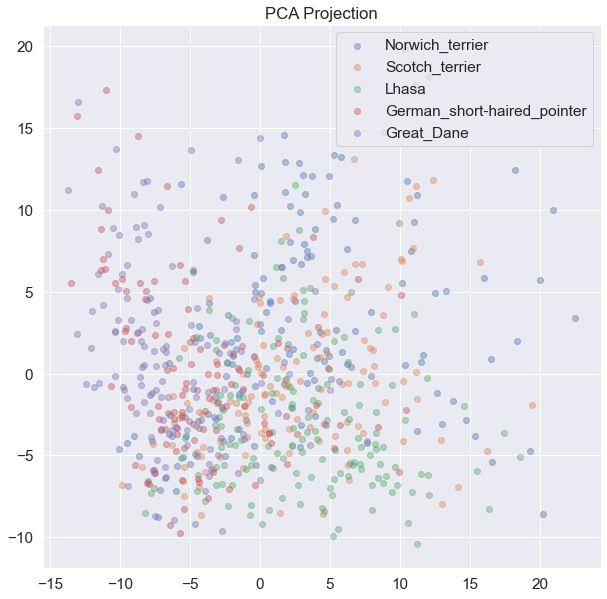

In [45]:
#On affiche les résultats obtenus
plt.subplots(figsize=(10,10))
#En prenant soin de distinguer les différentes classes
for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

A l'oeil nu il ne semble pas évident de distinguer les différentes classes. Néanmoins on ne compte pas faire la classification à l'oeil nu, nous allons plutôt ajouter deux couches fully-connected à notre CNN pour faire cette classification.

In [46]:
#On construit le modèle
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On le compile avec les mêmes paramètres que précédemment
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#On l'applique à nos données
history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
5/5 [==============================] - 1s 53ms/step - loss: 1.9496 - accuracy: 0.2704 - val_loss: 1.3951 - val_accuracy: 0.4853
Epoch 2/15
5/5 [==============================] - 0s 14ms/step - loss: 1.2352 - accuracy: 0.5685 - val_loss: 1.1899 - val_accuracy: 0.4779
Epoch 3/15
5/5 [==============================] - 0s 15ms/step - loss: 0.9312 - accuracy: 0.6333 - val_loss: 0.9918 - val_accuracy: 0.6838
Epoch 4/15
5/5 [==============================] - 0s 16ms/step - loss: 0.6962 - accuracy: 0.8056 - val_loss: 0.8969 - val_accuracy: 0.6618
Epoch 5/15
5/5 [==============================] - 0s 15ms/step - loss: 0.5103 - accuracy: 0.8870 - val_loss: 0.8572 - val_accuracy: 0.6838
Epoch 6/15
5/5 [==============================] - 0s 16ms/step - loss: 0.4112 - accuracy: 0.8778 - val_loss: 0.7908 - val_accuracy: 0.7206
Epoch 7/15
5/5 [==============================] - 0s 14ms/step - loss: 0.3120 - accuracy: 0.9370 - val_loss: 0.7731 - val_accuracy: 0.6912
Epoch 8/15
5/5 [===========

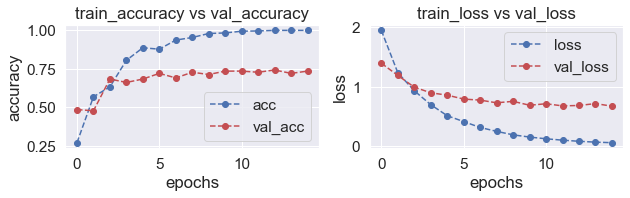

6/6 [==============================] - 0s 5ms/step - loss: 0.7247 - accuracy: 0.7391


In [47]:
#On affiche les performances
plot_accuracy_loss(history2)
test_loss = model2.evaluate(test_features, test_labels)

Les courbes montrent une nette amélioration par rapport à celles obtenues avec notre CNN. Vérifions les performances sur le jeu d'évaluation.

6/6 [==============================] - 0s 5ms/step


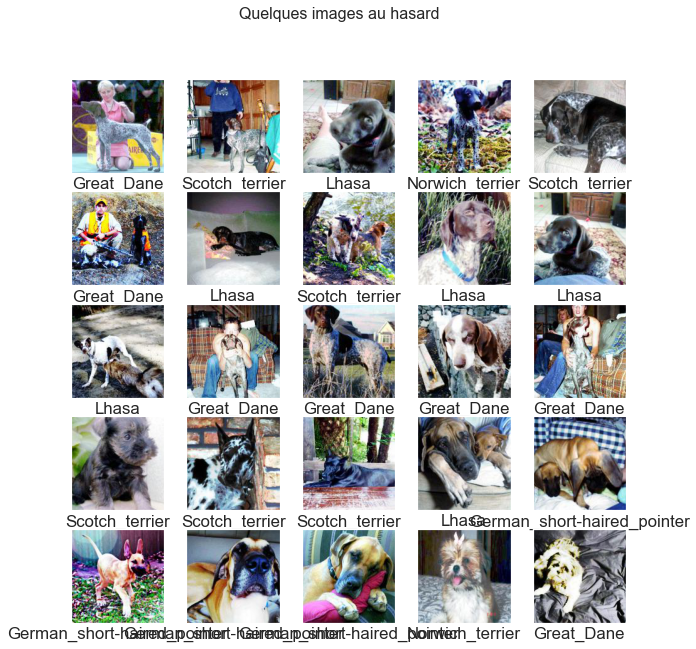

In [48]:
#On fait les prédictions sur le jeu de test
predictions = model2.predict(test_features)     
pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

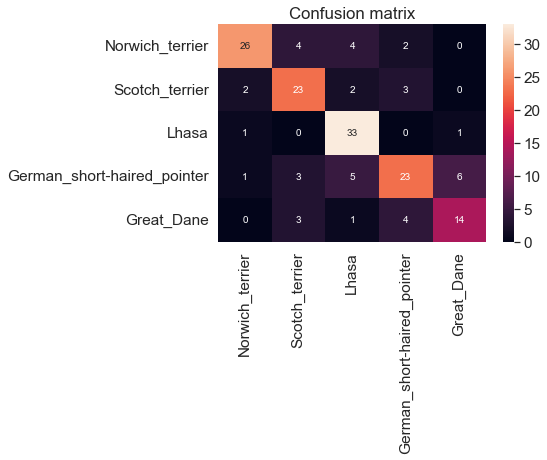

In [49]:
#On affiche la matrice de confusion
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Cette approche semble être **vraiment** plus performante que notre CNN construit de zéro. Néanmoins il peut ne s'agir que d'un manque d'informations lors de l'entraînement, puisque nous travaillons sur une banque de données réduite. Il nous faut pousser l'étude davantage en augmentant le nombre de races de chiens considérées. 

## Aggrandissement de la banque de données

Nous n'avions sélectionné que peu de races de chiens, afin d'avoir des temps de calcul et des occupations d'espace mémoire réduits. Idéalement il nous faudrait relancer tous nos algorithmes précédents sur la banque de données **entière**. Malheureusement traiter les 120 races de chiens est trop gourmand pour notre machine, et demanderait l'utilisation de méthodes de *cloud computing* par exemple. Nous allons devoir nous contenter de $35\%$ des races disponibles.

### Utilisation de notre CNN

La procédure est exactement la même que dans la section précédente, à ceci près que nous ajoutons plus de races dans notre banque de données.

In [50]:
#On prépare les chemins d'accès des répertoires d'entrée et de sortie, ainsi que la taille d'images voulue
in_dir = "database/original"
out_dir = "database_half"
size = 150

#On prépare nos images, avant de lister les étiquettes présentes
labels = prepare_data(in_dir, out_dir, size=size, sparse_data = .35, sparse_classes = True)

100%|███████████████████████████████████████████████████████████████████████████████| 169/169 [00:01<00:00, 129.69it/s]


In [51]:
#On crée un dictionnaire avec des indices associés à chaque classe possible
class_names = labels
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
#On extraie le nombre de classes différentes
nb_classes = len(class_names)
print(class_names)

['Pekinese', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'bluetick', 'black-and-tan_coonhound', 'Italian_greyhound', 'Norwegian_elkhound', 'Saluki', 'Border_terrier', 'Kerry_blue_terrier', 'Dandie_Dinmont', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'soft-coated_wheaten_terrier', 'golden_retriever', 'Labrador_retriever', 'Brittany_spaniel', 'clumber', 'Irish_water_spaniel', 'kuvasz', 'groenendael', 'briard', 'collie', 'miniature_pinscher', 'Bernese_mountain_dog', 'EntleBucher', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'malamute', 'pug', 'Great_Pyrenees', 'chow', 'Pembroke', 'toy_poodle', 'dhole', 'African_hunting_dog']


In [52]:
#On liste les chemins d'accès des jeux de train et de test
datasets = ['database_half/train', 'database_half/test']
#On récupère nos jeux de données
(train_images, train_labels), (test_images, test_labels) = load_data(datasets, class_names_label)
#On mélange les images du jeu d'entraînement, pour éviter un biais lors de l'entraînement séquentiel
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Loading database_half/train


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1161.18it/s]


Loading database_half/test


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1002.72it/s]


Brève analyse des bases d'images utilisées :

In [53]:
#On récupère le nombre d'images dans les deux jeux de données
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
#On les affiche, ainsi que la taille choisie pour les images
print ("Nombre d'images d'entraînement : {}".format(n_train))
print ("Nombre d'images d'évaluation : {}".format(n_test))
print ("Chaque image est de taille : {} pixels par {} pixels".format(size, size))

Nombre d'images d'entraînement : 5408
Nombre d'images d'évaluation : 1328
Chaque image est de taille : 150 pixels par 150 pixels


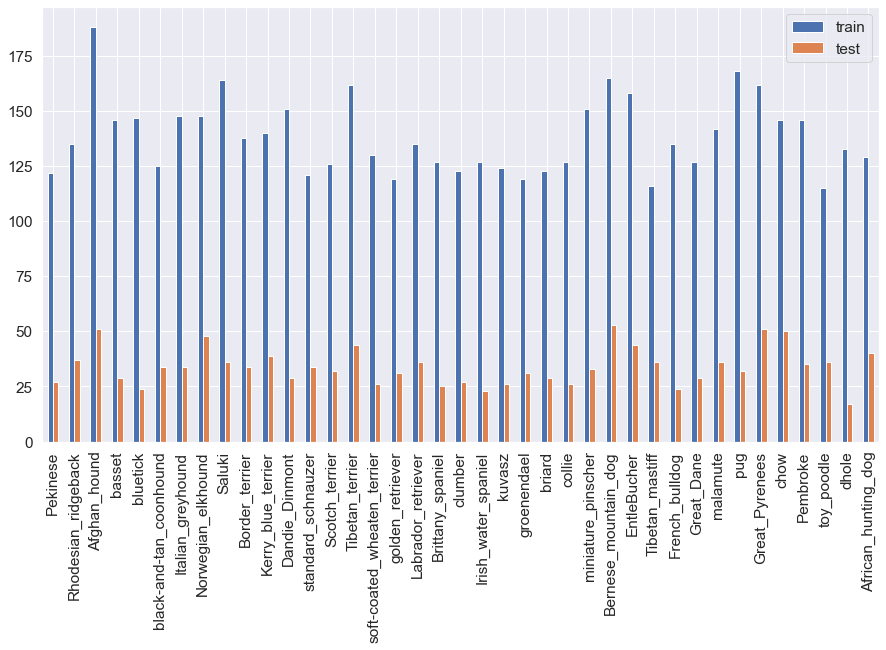

In [54]:
#On compte et affiche combien il y a d'images de chaque classe dans chaque jeu de données
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar(figsize = (15,8))
plt.show()

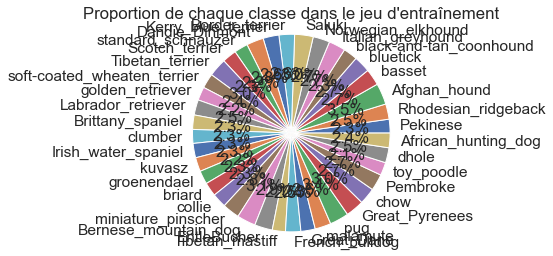

In [55]:
#On calcule et affiche les proportions de chaque classe dans le jeu d'entraînement
plt.pie(train_counts, explode=np.zeros(nb_classes), labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Proportion de chaque classe dans le jeu d'entraînement")
plt.show()

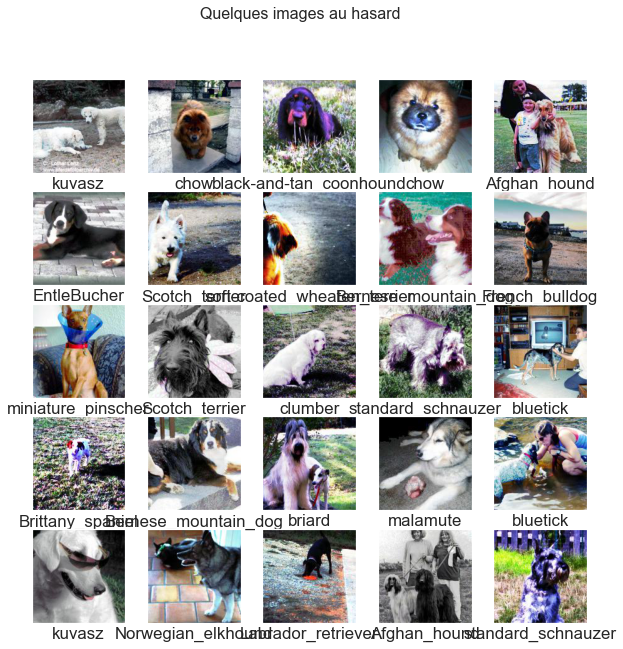

In [56]:
#On affiche 25 images pour visualiser notre jeu de données
display_examples(class_names, train_images, train_labels)

In [57]:
#On renormalise les valeurs numériques pour avoir des entrées entre 0 et 1
train_images = train_images / 255.0 
test_images = test_images / 255.0

Construction du CNN :

In [58]:
#On construit notre CNN en empilant les couches successives
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On compile le modèle
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
34/34 [==============================] - 6s 142ms/step - loss: 3.7932 - accuracy: 0.0337 - val_loss: 3.6519 - val_accuracy: 0.0462
Epoch 2/20
34/34 [==============================] - 4s 107ms/step - loss: 3.5882 - accuracy: 0.0654 - val_loss: 3.5752 - val_accuracy: 0.0518
Epoch 3/20
34/34 [==============================] - 4s 107ms/step - loss: 3.2269 - accuracy: 0.1570 - val_loss: 3.5271 - val_accuracy: 0.0804
Epoch 4/20
34/34 [==============================] - 4s 107ms/step - loss: 2.4806 - accuracy: 0.3530 - val_loss: 3.6804 - val_accuracy: 0.0878
Epoch 5/20
34/34 [==============================] - 4s 108ms/step - loss: 1.4849 - accuracy: 0.6153 - val_loss: 4.2204 - val_accuracy: 0.0915
Epoch 6/20
34/34 [==============================] - 4s 108ms/step - loss: 0.6093 - accuracy: 0.8597 - val_loss: 5.1024 - val_accuracy: 0.0850
Epoch 7/20
34/34 [==============================] - 4s 109ms/step - loss: 0.1522 - accuracy: 0.9792 - val_loss: 6.1287 - val_accuracy: 0.0869
Epoch 

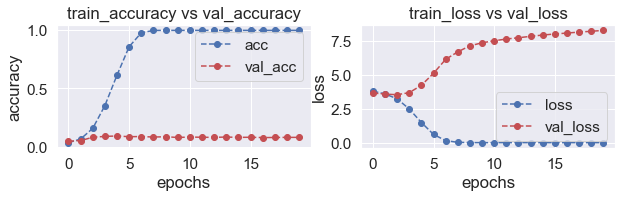

In [60]:
#On affiche les performances au cours de l'entraînement
plot_accuracy_loss(history)

In [61]:
test_loss = model.evaluate(test_images, test_labels)

42/42 [==============================] - 1s 15ms/step - loss: 8.2948 - accuracy: 0.0934


Pour limiter le sur-apprentissage, nous allons nous arrêter à $3$ epochs.

In [62]:
#On construit notre CNN en empilant les couches successives
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On compile le modèle
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=128, epochs=3, validation_split = 0.2)

Epoch 1/3
34/34 [==============================] - 5s 120ms/step - loss: 3.7860 - accuracy: 0.0280 - val_loss: 3.6457 - val_accuracy: 0.0314
Epoch 2/3
34/34 [==============================] - 4s 106ms/step - loss: 3.6034 - accuracy: 0.0580 - val_loss: 3.5717 - val_accuracy: 0.0555
Epoch 3/3
34/34 [==============================] - 4s 107ms/step - loss: 3.3581 - accuracy: 0.1244 - val_loss: 3.4537 - val_accuracy: 0.0896


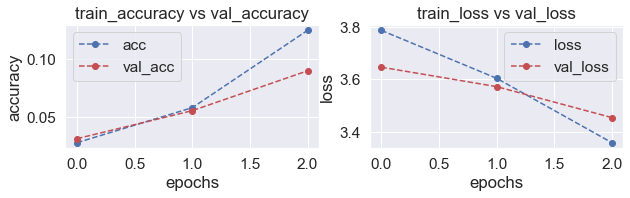

In [63]:
#On affiche les performances au cours de l'entraînement
plot_accuracy_loss(history)

In [64]:
test_loss = model.evaluate(test_images, test_labels)

42/42 [==============================] - 1s 14ms/step - loss: 3.4914 - accuracy: 0.0911


### Transfer Learning

Puisqu'elle semblait efficace, nous allons à nouveau utiliser l'approche de Tranfer Learning précédente, i.e. charger les couches inférieures du CNN VGG16 pour faire la détection des features, avant d'y ajouter deux couches fully-connected pour effectuer la classification.

In [65]:
#On importe le modèle grâce à keras, sans ses couches supérieures
model = VGG16(weights='imagenet', include_top=False)

In [66]:
#On l'applique sur nos images pour identifier des features visuelles
train_features = model.predict(train_images)
test_features = model.predict(test_images)

42/42 [==============================] - 6s 135ms/step


In [67]:
#On récupère les tailles de nos données
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z
#On construit le modèle
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On le compile avec les mêmes paramètres que précédemment
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#On l'applique à nos données
history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
34/34 [==============================] - 1s 13ms/step - loss: 3.6398 - accuracy: 0.0405 - val_loss: 3.5991 - val_accuracy: 0.0388
Epoch 2/15
34/34 [==============================] - 0s 9ms/step - loss: 3.4763 - accuracy: 0.0754 - val_loss: 3.4882 - val_accuracy: 0.0730
Epoch 3/15
34/34 [==============================] - 0s 8ms/step - loss: 3.3063 - accuracy: 0.1276 - val_loss: 3.3748 - val_accuracy: 0.1155
Epoch 4/15
34/34 [==============================] - 0s 8ms/step - loss: 3.1234 - accuracy: 0.1687 - val_loss: 3.2798 - val_accuracy: 0.1359
Epoch 5/15
34/34 [==============================] - 0s 8ms/step - loss: 2.9413 - accuracy: 0.1990 - val_loss: 3.1564 - val_accuracy: 0.1442
Epoch 6/15
34/34 [==============================] - 0s 8ms/step - loss: 2.7574 - accuracy: 0.2423 - val_loss: 3.0683 - val_accuracy: 0.1710
Epoch 7/15
34/34 [==============================] - 0s 8ms/step - loss: 2.6077 - accuracy: 0.2691 - val_loss: 2.9673 - val_accuracy: 0.1811
Epoch 8/15
34/34 [=

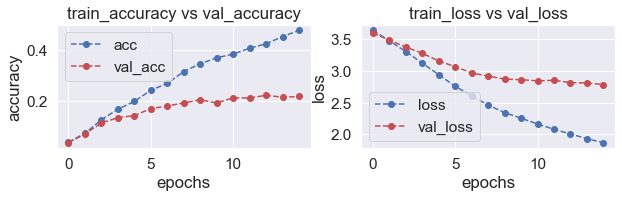

42/42 [==============================] - 0s 5ms/step - loss: 2.7393 - accuracy: 0.2342


In [68]:
#On affiche les performances
plot_accuracy_loss(history2)
test_loss = model2.evaluate(test_features, test_labels)

42/42 [==============================] - 0s 3ms/step


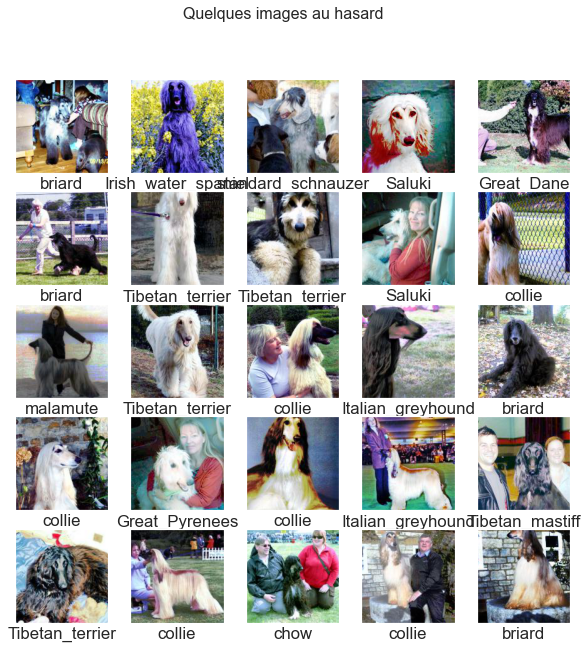

In [69]:
#On fait les prédictions sur le jeu de test
predictions = model2.predict(test_features)     
pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

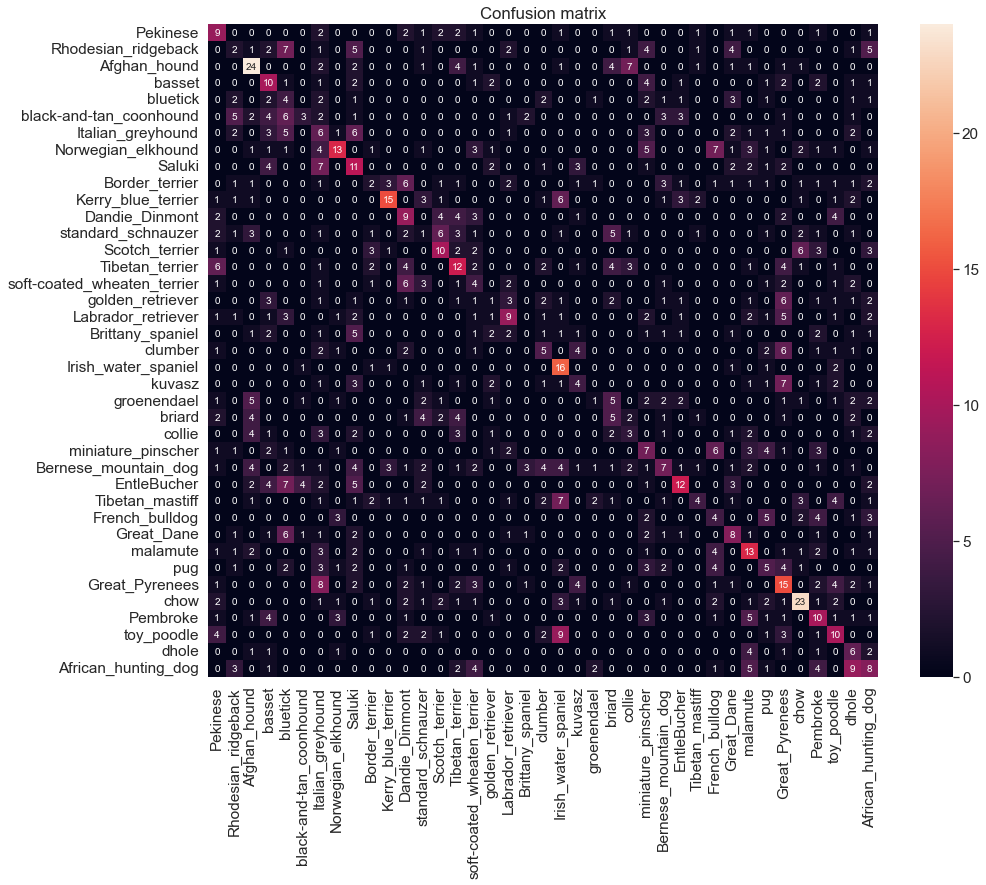

In [70]:
#On affiche la matrice de confusion
CM = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize=(15,12))
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Il semble y avoir peu d'erreurs dans le jeu de test, et la précision est nettement supérieure à celle de notre CNN optimisé. Nous conserverons donc le VGG16 comme modèle final.

## Banque de données complète

Jusqu'à maintenant nous avions réduit le nombre de classes étudiées pour avoir une base de données suffisamment petite **sans perdre trop d'information dans chaque classe**. Cependant dans le contexte de Transfer learning l'apprentissage des features (et donc l'information retenue par le modèle) a déjà été réalisé en amont. Nous allons voir si cela nous permet de conserver de bonnes performances tout en ayant une classification sur **toutes** les races de chiens à notre disposition, en appliquant l'algorithme VGG16 sur une banque de données contenant la moitié des images, répartie dans toutes les races disponibles.

In [71]:
#On prépare les chemins d'accès des répertoires d'entrée et de sortie, ainsi que la taille d'images voulue
in_dir = "database/original"
out_dir = "database_complete"
size = 150

#On prépare nos images, avant de lister les étiquettes présentes
labels = prepare_data(in_dir, out_dir, size=size, sparse_data = .35, sparse_classes = False)

100%|███████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 383.87it/s]


In [72]:
#On crée un dictionnaire avec des indices associés à chaque classe possible
class_names = labels
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
#On extraie le nombre de classes différentes
nb_classes = len(class_names)
print(class_names)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur

In [73]:
#On liste les chemins d'accès des jeux de train et de test
datasets = ['database_complete/train', 'database_complete/test']
#On récupère nos jeux de données
(train_images, train_labels), (test_images, test_labels) = load_data(datasets, class_names_label)
#On mélange les images du jeu d'entraînement, pour éviter un biais lors de l'entraînement séquentiel
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Loading database_complete/train


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1007.08it/s]


Loading database_complete/test


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1002.75it/s]


Brève analyse des bases d'images utilisées :

In [74]:
#On récupère le nombre d'images dans les deux jeux de données
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
#On les affiche, ainsi que la taille choisie pour les images
print ("Nombre d'images d'entraînement : {}".format(n_train))
print ("Nombre d'images d'évaluation : {}".format(n_test))
print ("Chaque image est de taille : {} pixels par {} pixels".format(size, size))

Nombre d'images d'entraînement : 5806
Nombre d'images d'évaluation : 1461
Chaque image est de taille : 150 pixels par 150 pixels


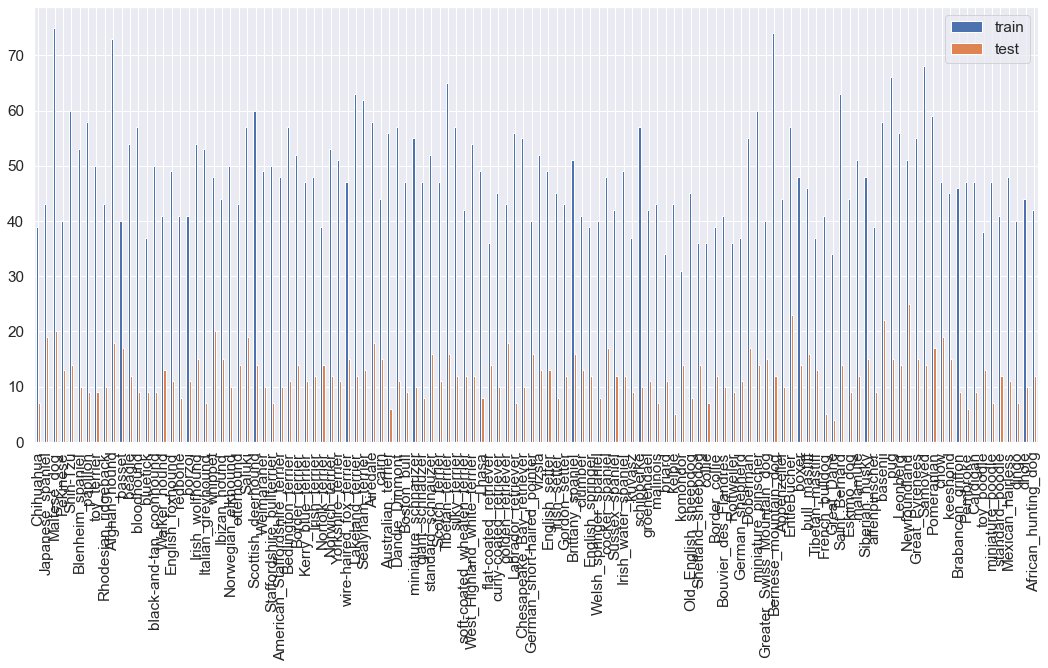

In [75]:
#On compte et affiche combien il y a d'images de chaque classe dans chaque jeu de données
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar(figsize = (18,8))
plt.show()

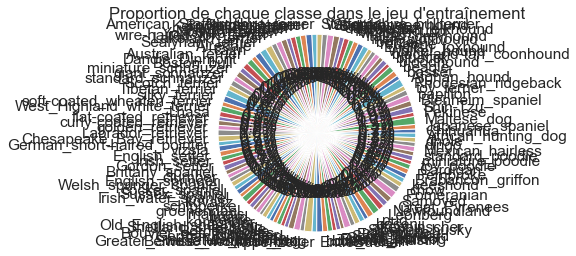

In [76]:
#On calcule et affiche les proportions de chaque classe dans le jeu d'entraînement
plt.pie(train_counts, explode=np.zeros(nb_classes), labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Proportion de chaque classe dans le jeu d'entraînement")
plt.show()

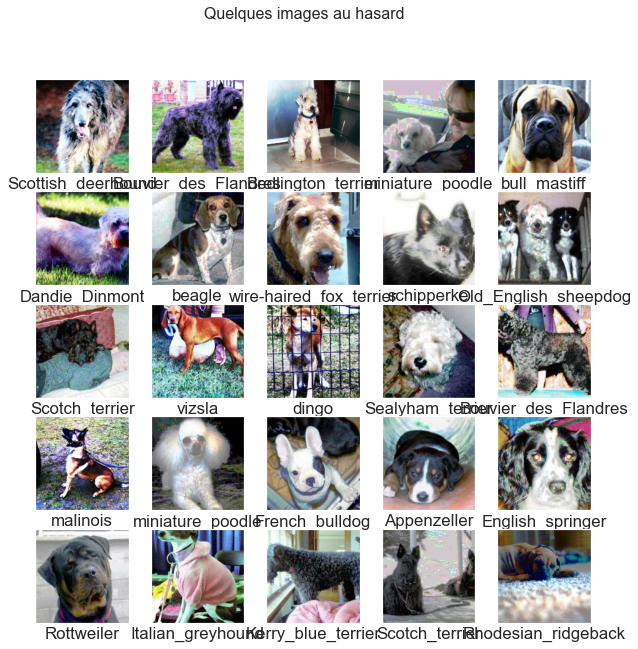

In [77]:
#On affiche 25 images pour visualiser notre jeu de données
display_examples(class_names, train_images, train_labels)

In [78]:
#On renormalise les valeurs numériques pour avoir des entrées entre 0 et 1
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [79]:
#On importe le modèle grâce à keras, sans ses couches supérieures
model = VGG16(weights='imagenet', include_top=False)

In [80]:
#On l'applique sur nos images pour identifier des features visuelles
train_features = model.predict(train_images)
test_features = model.predict(test_images)

46/46 [==============================] - 6s 136ms/step


In [81]:
#On récupère les tailles de nos données
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z
#On construit le modèle
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax)
])
#On le compile avec les mêmes paramètres que précédemment
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#On l'applique à nos données
history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
37/37 [==============================] - 1s 13ms/step - loss: 4.7709 - accuracy: 0.0157 - val_loss: 4.7185 - val_accuracy: 0.0258
Epoch 2/15
37/37 [==============================] - 0s 9ms/step - loss: 4.6226 - accuracy: 0.0295 - val_loss: 4.6185 - val_accuracy: 0.0293
Epoch 3/15
37/37 [==============================] - 0s 8ms/step - loss: 4.4205 - accuracy: 0.0538 - val_loss: 4.4982 - val_accuracy: 0.0379
Epoch 4/15
37/37 [==============================] - 0s 8ms/step - loss: 4.1777 - accuracy: 0.0825 - val_loss: 4.3454 - val_accuracy: 0.0620
Epoch 5/15
37/37 [==============================] - 0s 8ms/step - loss: 3.9045 - accuracy: 0.1206 - val_loss: 4.2041 - val_accuracy: 0.0577
Epoch 6/15
37/37 [==============================] - 0s 9ms/step - loss: 3.6535 - accuracy: 0.1639 - val_loss: 4.1139 - val_accuracy: 0.0620
Epoch 7/15
37/37 [==============================] - 0s 8ms/step - loss: 3.4256 - accuracy: 0.1964 - val_loss: 3.9947 - val_accuracy: 0.0809
Epoch 8/15
37/37 [=

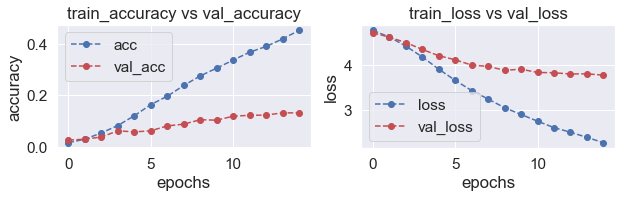

46/46 [==============================] - 0s 5ms/step - loss: 3.7010 - accuracy: 0.1437


In [82]:
#On affiche les performances
plot_accuracy_loss(history2)
test_loss = model2.evaluate(test_features, test_labels)

46/46 [==============================] - 0s 3ms/step


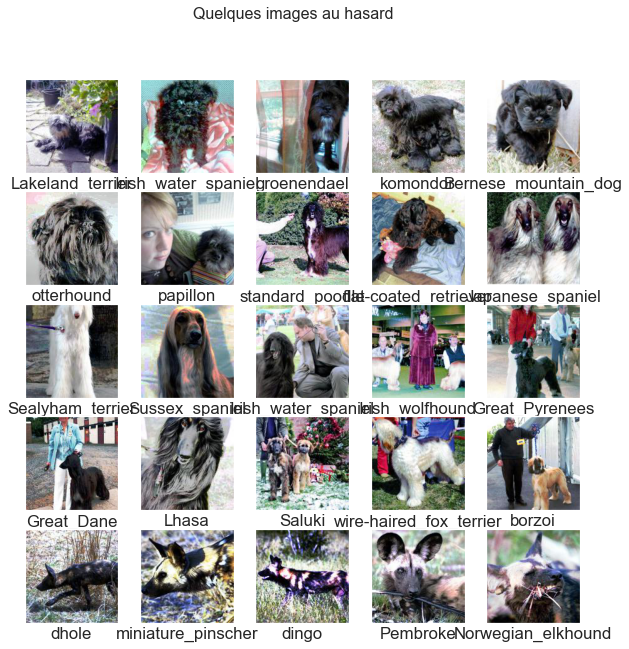

In [83]:
#On fait les prédictions sur le jeu de test
predictions = model2.predict(test_features)     
pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

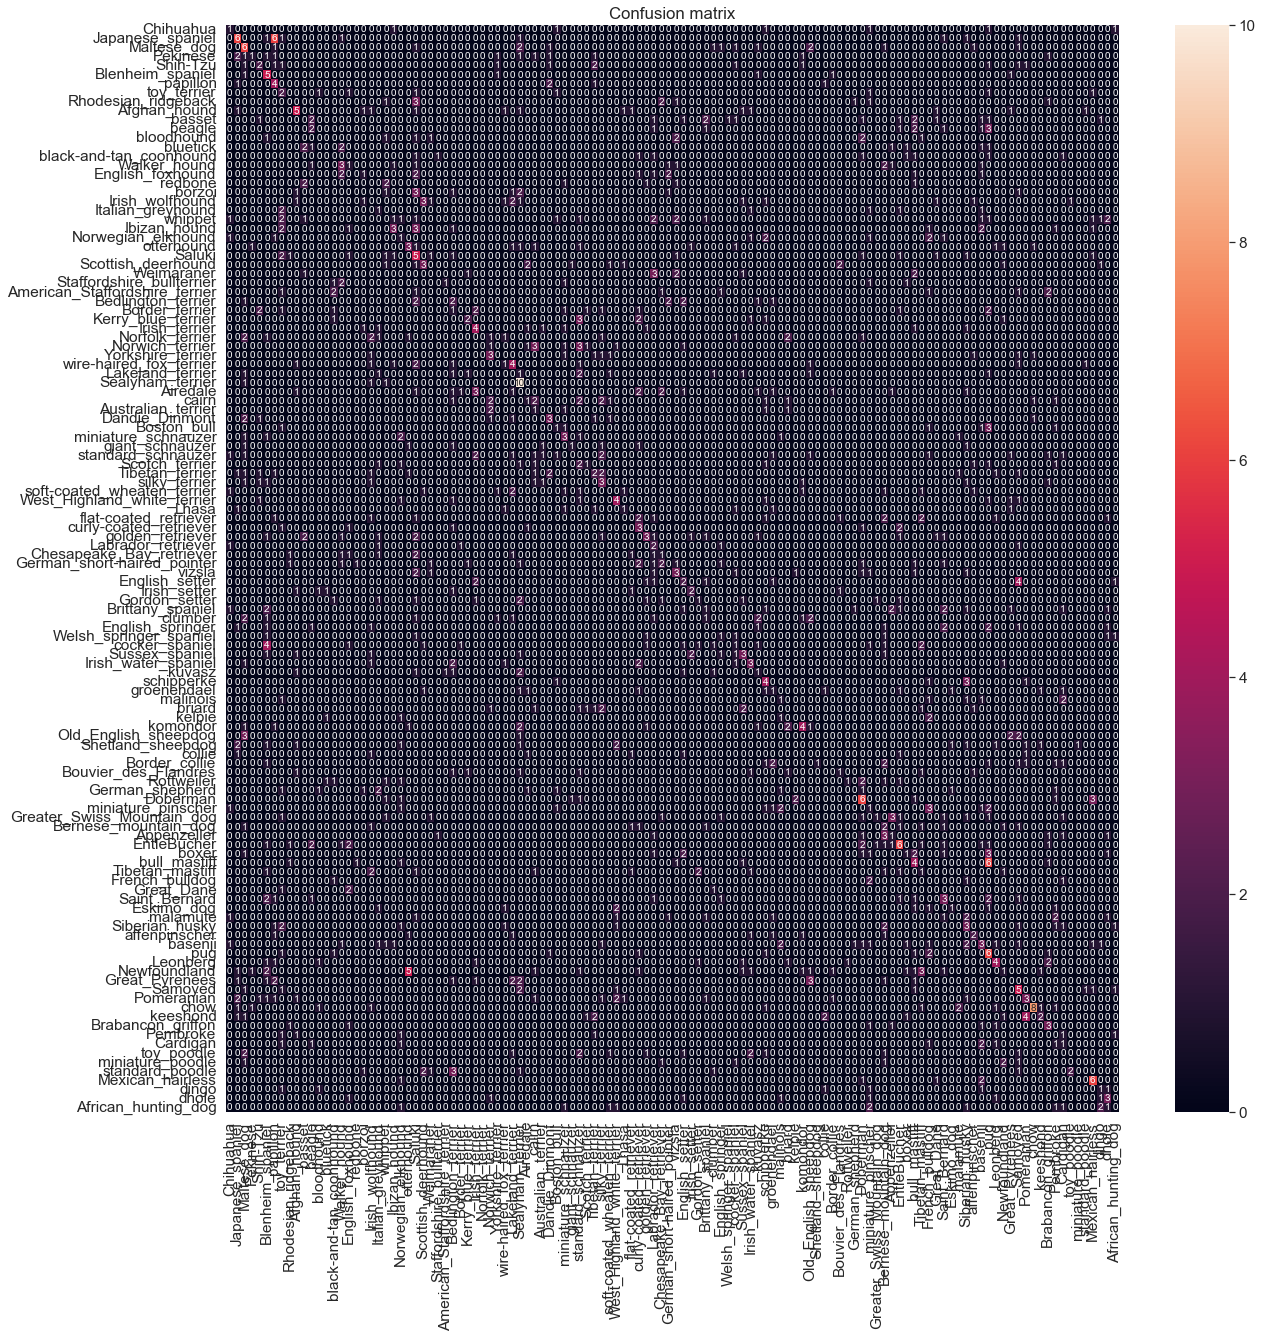

In [84]:
#On affiche la matrice de confusion
CM = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize=(20,20))
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

On voit clairement que certaines races peinent à être identifiées, le manque d'images dans chaque classe est un sérieux problème ici. Nous allons néanmoins exporter ce classifieur pour notre déploiement, faute de mieux.

In [87]:
import pickle
#On exporte le dictionnaire d'équivalence races/labels via pickle
with open('classes.pi', 'wb') as f1:
    pickle.dump(class_names_label, f1)

In [86]:
#On exporte le classifieur via keras (le feature detector sera chargé via keras comme nous l'avons fait plus tôt)
keras_model_path = "./keras_save"
model2.save(keras_model_path)

INFO:tensorflow:Assets written to: ./keras_save\assets
